# Intro

I just mess around with GPs in this script



In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import xarray as xr

import math
import os, sys, shutil
import json

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import arviz as az

import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample

import theano.tensor as T
from theano import shared
from theano.tensor.nlinalg import matrix_inverse

print(f"Running on PyMC3 v{pm.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.5


# Defining some functions

In [2]:


def print_all_df(df):
    """
    This function simply prints an entire pandas dataframe by changing the global pandas settings,
    printing and then reverting the settings.
    """
    # Permanently changes the pandas settings
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', -1)
    
    # All dataframes hereafter reflect these changes.
    display(df)
    
    print('**RESET_OPTIONS**')
    
    # Resets the options
    pd.reset_option('all')
    



# Import tidy master dataset

In [3]:
os.chdir('/app/data/')

all_data = pd.read_csv("master_tidy_dataset.csv")

all_data

Well   Sample ID  Time (Minutes)  RFUs  Gain Setting Chromatic Settings  \
0      B12   Sample X1               0  3323          1500          485_520_2   
1      B13   Sample X2               0  3397          1500          485_520_2   
2      B14   Sample X3               0  3221          1500          485_520_2   
3      B15   Sample X4               0  3233          1500          485_520_2   
4      B16   Sample X5               0  3220          1500          485_520_2   
...    ...         ...             ...   ...           ...                ...   
13715  J13   Sample X6             718   148           800            485_520   
13716  J15   Sample X7             718    76           800            485_520   
13717  J17   Sample X8             718    98           800            485_520   
13718  J19   Sample X9             718    76           800            485_520   
13719  J21  Sample X10             718   110           800            485_520   

      Expression Product Amplicon DNA Template Energy Solution Reaction Type  \
0                    GFP         s70_deGFP_MGA  Michael_ES_001          TXTL   
1                    GFP         s70_deGFP_MGA  Michael_ES_001          TXTL   
2                    GFP         s70_deGFP_MGA  Michael_ES_001          TXTL   
3                    GFP         s70_deGFP_MGA  Michael_ES_001          TXTL   
4                    GFP         s70_deGFP_MGA  Michael_ES_001          TXTL   
...                  ...                   ...             ...           ...   
13715                GFP         s70_deGFP_MGA  Michael_ES_001          TXTL   
13716                GFP         s70_deGFP_MGA  Michael_ES_001          TXTL   
13717                GFP         s70_deGFP_MGA  Michael_ES_001          TXTL   
13718                GFP         s70_deGFP_MGA  Michael_ES_001          TXTL   
13719                GFP         s70_deGFP_MGA  Michael_ES_001          TXTL   

       ...  lysate_aspirate_height_inc substrates_aspirate_height_init  \
0      ...                         0.4                             9.0   
1      ...                         0.4                             9.0   
2      ...                         0.4                             9.0   
3      ...                         0.4                             9.0   
4      ...                         0.4                             9.0   
...    ...                         ...                             ...   
13715  ...                         0.4                             8.6   
13716  ...                         0.4                             8.6   
13717  ...                         0.4                             8.6   
13718  ...                         0.4                             8.6   
13719  ...                         0.4                             8.6   

       substrates_aspirate_height_inc wax_dispense_volume wax_dispense_height  \
0                                 0.4                  35                   5   
1                                 0.4                  35                   5   
2                                 0.4                  35                   5   
3                                 0.4                  35                   5   
4                                 0.4                  35                   5   
...                               ...                 ...                 ...   
13715                             0.4                  35                  -3   
13716                             0.4                  35                  -3   
13717                             0.4                  35                  -3   
13718                             0.4                  35                  -3   
13719                             0.4                  35                  -3   

       wax_new_tip  wax_touch_tip  wax_air_gap  wax_disposal_volume  \
0            never           True           20                   30   
1            never           True           20                   30 

# Trim data to only get GFP gain 800 at time 180 mins

In [4]:
Selection = all_data[all_data['Expression Product'] == "GFP"].copy()
Selection = Selection[Selection['Gain Setting'] == 800]
Selection = Selection[Selection["Time (Minutes)"] == 180]


# Generate summary stats:

Mean and SEM for each experiment

In [5]:

exp_slct_list = []
for exp in Selection['Experiment #'].unique():
    
    exp_slct = Selection[Selection['Experiment #'] == exp].copy()
    
    exp_slct['Mean'] = exp_slct['RFUs'].mean()
    exp_slct['SEM'] = exp_slct['RFUs'].sem()
    
    exp_slct_list.append(exp_slct)

Selection = pd.concat(exp_slct_list,axis=0)
Selection['SEM/Mean'] = Selection['SEM']/Selection['Mean']


In [6]:
Selection.columns

Index(['Well', 'Sample ID', 'Time (Minutes)', 'RFUs', 'Gain Setting',
       'Chromatic Settings', 'Expression Product', 'Amplicon DNA Template',
       'Energy Solution', 'Reaction Type', 'Replicate', 'System',
       'Reaction Temperature (°C)', 'Performed by', 'Instrument',
       'Experiment #', 'lysate_aspirate_height_init',
       'lysate_aspirate_height_inc', 'substrates_aspirate_height_init',
       'substrates_aspirate_height_inc', 'wax_dispense_volume',
       'wax_dispense_height', 'wax_new_tip', 'wax_touch_tip', 'wax_air_gap',
       'wax_disposal_volume', 'Assay Date', 'Mean', 'SEM', 'SEM/Mean'],
      dtype='object')

In [7]:

new =  Selection[["SEM/Mean", "substrates_aspirate_height_inc","substrates_aspirate_height_init", "lysate_aspirate_height_inc", "lysate_aspirate_height_init"]]

new = new.drop_duplicates()

new = new.reset_index(drop=True)

In [8]:
new

SEM/Mean  substrates_aspirate_height_inc  substrates_aspirate_height_init  \
0  0.010083                             0.4                              9.0   
1  0.035281                             0.4                              9.0   
2  0.374904                             0.4                              9.0   
3  0.023406                             0.4                              8.6   

   lysate_aspirate_height_inc  lysate_aspirate_height_init  
0                         0.4                          4.5  
1                         0.4                          4.5  
2                         0.4                          4.5  
3                         0.4                          4.5

# Set up 2d GP

In [9]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano.tensor as T

from pymc3 import (
    NUTS,
    Deterministic,
    HalfCauchy,
    Model,
    MvNormal,
    find_MAP,
    sample,
    summary,
    traceplot,
)
from theano import shared
from theano.tensor.nlinalg import matrix_inverse

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.5


In [10]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

We assume that their is a relationship between our predictor variables (e.g. x) and our effector variables (y). In a multivariate GP, there can be multiple predictor variables. e.g. height and weight predicting speed. *n.b. height and weight would be handled as 'coordinates'*

$$ y=f(x) $$

In [11]:
"""# fmt: off
x = np.array([-5, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4, 
-3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3, -2.9, 
-2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2, -1.9, -1.8, 
-1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1, -0.9, -0.8, -0.7, 
-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 
0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 
1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 
3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 
4.5, 4.6, 4.7, 4.8, 4.9, 5])

(-5, 1.04442478194401)

(-4.9, 0.948306088493654)

y = np.array([1.04442478194401, 0.948306088493654, 0.357037759697332, 0.492336514646604, 
0.520651364364746, 0.112629866592809, 0.470995468454158, -0.168442254267804, 
0.0720344402575861, -0.188108980535916, -0.0160163306512027, 
-0.0388792158617705, -0.0600673630622568, 0.113568725264636, 
0.447160403837629, 0.664421188556779, -0.139510743820276, 0.458823971660986, 
0.141214654640904, -0.286957663528091, -0.466537724021695, -0.308185884317105, 
-1.57664872694079, -1.44463024170082, -1.51206214603847, -1.49393593601901, 
-2.02292464164487, -1.57047488853653, -1.22973445533419, -1.51502367058357, 
-1.41493587255224, -1.10140254663611, -0.591866485375275, -1.08781838696462, 
-0.800375653733931, -1.00764767602679, -0.0471028950122742, -0.536820626879737, 
-0.151688056391446, -0.176771681318393, -0.240094952335518, -1.16827876746502, 
-0.493597351974992, -0.831683011472805, -0.152347043914137, 0.0190364158178343, 
-1.09355955218051, -0.328157917911376, -0.585575679802941, -0.472837120425201, 
-0.503633622750049, -0.0124446353828312, -0.465529814250314, 
-0.101621725887347, -0.26988462590405, 0.398726664193302, 0.113805181040188, 
0.331353802465398, 0.383592361618461, 0.431647298655434, 0.580036473774238, 
0.830404669466897, 1.17919105883462, 0.871037583886711, 1.12290553424174, 
0.752564860804382, 0.76897960270623, 1.14738839410786, 0.773151715269892, 
0.700611498974798, 0.0412951045437818, 0.303526087747629, -0.139399513324585, 
-0.862987735433697, -1.23399179134008, -1.58924289116396, -1.35105117911049, 
-0.990144529089174, -1.91175364127672, -1.31836236129543, -1.65955735224704, 
-1.83516148300526, -2.03817062501248, -1.66764011409214, -0.552154350554687, 
-0.547807883952654, -0.905389222477036, -0.737156477425302, -0.40211249920415, 
0.129669958952991, 0.271142753510592, 0.176311762529962, 0.283580281859344, 
0.635808289696458, 1.69976647982837, 1.10748978734239, 0.365412229181044, 
0.788821368082444, 0.879731888124867, 1.02180766619069, 0.551526067300283])
# fmt: on
N = len(y)


print(N)
"""

'# fmt: off\nx = np.array([-5, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4, \n-3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3, -2.9, \n-2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2, -1.9, -1.8, \n-1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1, -0.9, -0.8, -0.7, \n-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, \n0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, \n1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, \n3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, \n4.5, 4.6, 4.7, 4.8, 4.9, 5])\n\n(-5, 1.04442478194401)\n\n(-4.9, 0.948306088493654)\n\ny = np.array([1.04442478194401, 0.948306088493654, 0.357037759697332, 0.492336514646604, \n0.520651364364746, 0.112629866592809, 0.470995468454158, -0.168442254267804, \n0.0720344402575861, -0.188108980535916, -0.0160163306512027, \n-0.0388792158617705, -0.0600673630622568, 0.113568725264636, \n0.447160403837629, 0.664421188556779, -0.139510743820276, 0.458823971

In [12]:
# fmt: off
x = np.array([-5, -2, 2, 3.5, 4])


y = np.array([-5, -1, -3, 5, 4])*20
# fmt: on
N = len(y)


print(N)

5


In order to calculate how related two points are to eachother, we can calculate the squared distance between them.

$$(x-x')^2$$


We calculate the distance of every predictor variable to every other predictor



In [13]:
squared_distance = lambda x, y: np.array(
    [[(x[i] - y[j]) ** 2 for i in range(len(x))] for j in range(len(y))]
)


squared_distance_2 = lambda x, y: np.array(
    [[(print(x[i], y[j]))  for i in range(len(x))] for j in range(len(y))]
)


def sqd_dist(x, y):
    
    #init empty list
    result_list = []

    for j in range(len(y)):
        
        for i in range(len(x)):
        
            # generate squared difference between x and y and append to list
            result_list.append((x[i]-y[j])**2)
    
    # return said list as a numpy array
    return np.array(result_list).reshape(-1)



D = squared_distance(x, x)

D2 = squared_distance_2(x, x)
print(D[0])

d = sqd_dist(x, x)
print(len(d))

-5.0 -5.0
-2.0 -5.0
2.0 -5.0
3.5 -5.0
4.0 -5.0
-5.0 -2.0
-2.0 -2.0
2.0 -2.0
3.5 -2.0
4.0 -2.0
-5.0 2.0
-2.0 2.0
2.0 2.0
3.5 2.0
4.0 2.0
-5.0 3.5
-2.0 3.5
2.0 3.5
3.5 3.5
4.0 3.5
-5.0 4.0
-2.0 4.0
2.0 4.0
3.5 4.0
4.0 4.0
[ 0.    9.   49.   72.25 81.  ]
25


In [14]:
with Model() as gp_fit:
    
    
    # are we assuming that the mean is zero? 
    # i.e. this is this the prior?
    # in the absence of data the function will revert back to zero?
    #μ = np.zeros(N)
    μ = np.array([100,100,100,100,100])
    
    # are these the priors / distributions for each dimension including error?
    # Cauchy (a.k.a lorentz distrbution) is a continuous probabilty distribution
    # A half Cauchy has a mean of 0 and only takes positive values
    # the numerical argument is the standard deviation
    η_sq = HalfCauchy("η_sq", 1)
    ρ_sq = HalfCauchy("ρ_sq", 1)
    
    # noise co-variance
    # how much noise is expected to be present in the data: larger = more independent
    # smaller - the closer the distribution of functions will collapse around the observed data point
    σ_sq = HalfCauchy("σ_sq", 0.01)
    
    # generate squared differences between the x dim and itself
    D = squared_distance(x, x)
    
    # We can now use the squared differences to generate our kernel function
    
    # Squared exponential
    # This generates the convariance matrix
    Σ = T.fill_diagonal(η_sq * T.exp(-ρ_sq * D), η_sq + σ_sq)

    obs = MvNormal("obs", μ, Σ, observed=y)

<AxesSubplot:>

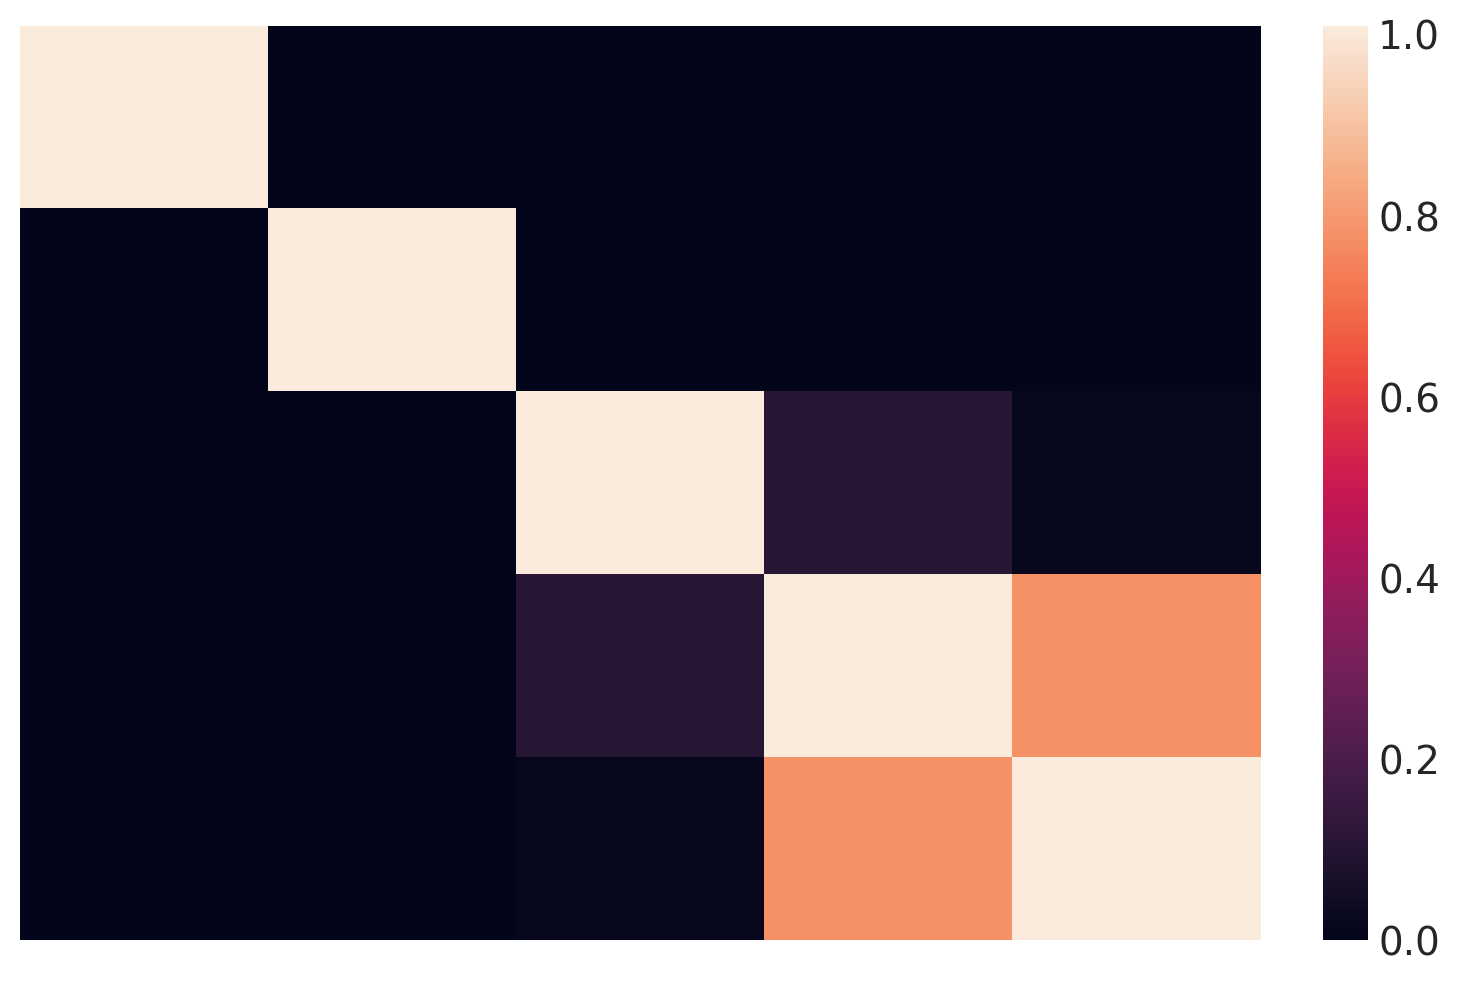

In [15]:
sns.heatmap(Σ.tag.test_value, xticklabels=False, yticklabels=False)

In [16]:
with gp_fit:

    # Prediction over grid
    xgrid = np.linspace(-6, 6)
    D_pred = squared_distance(xgrid, xgrid)
    D_off_diag = squared_distance(x, xgrid)

    # Covariance matrices for prediction
    Σ_pred = η_sq * T.exp(-ρ_sq * D_pred)
    Σ_off_diag = η_sq * T.exp(-ρ_sq * D_off_diag)

    # Posterior mean
    μ_post = Deterministic("μ_post", T.dot(T.dot(Σ_off_diag, matrix_inverse(Σ)), y))
    
    # Posterior covariance
    Σ_post = Deterministic(
        "Σ_post", Σ_pred - T.dot(T.dot(Σ_off_diag, matrix_inverse(Σ)), Σ_off_diag.T)
    )

In [17]:
with gp_fit:
    svgd_approx = pm.fit(400, method="svgd", inf_kwargs=dict(n_particles=500))

In [18]:
gp_trace = svgd_approx.sample(1000)

/tmp/ipykernel_11/2010266863.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(gp_trace, var_names=["η_sq", "ρ_sq", "σ_sq"]);
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you us

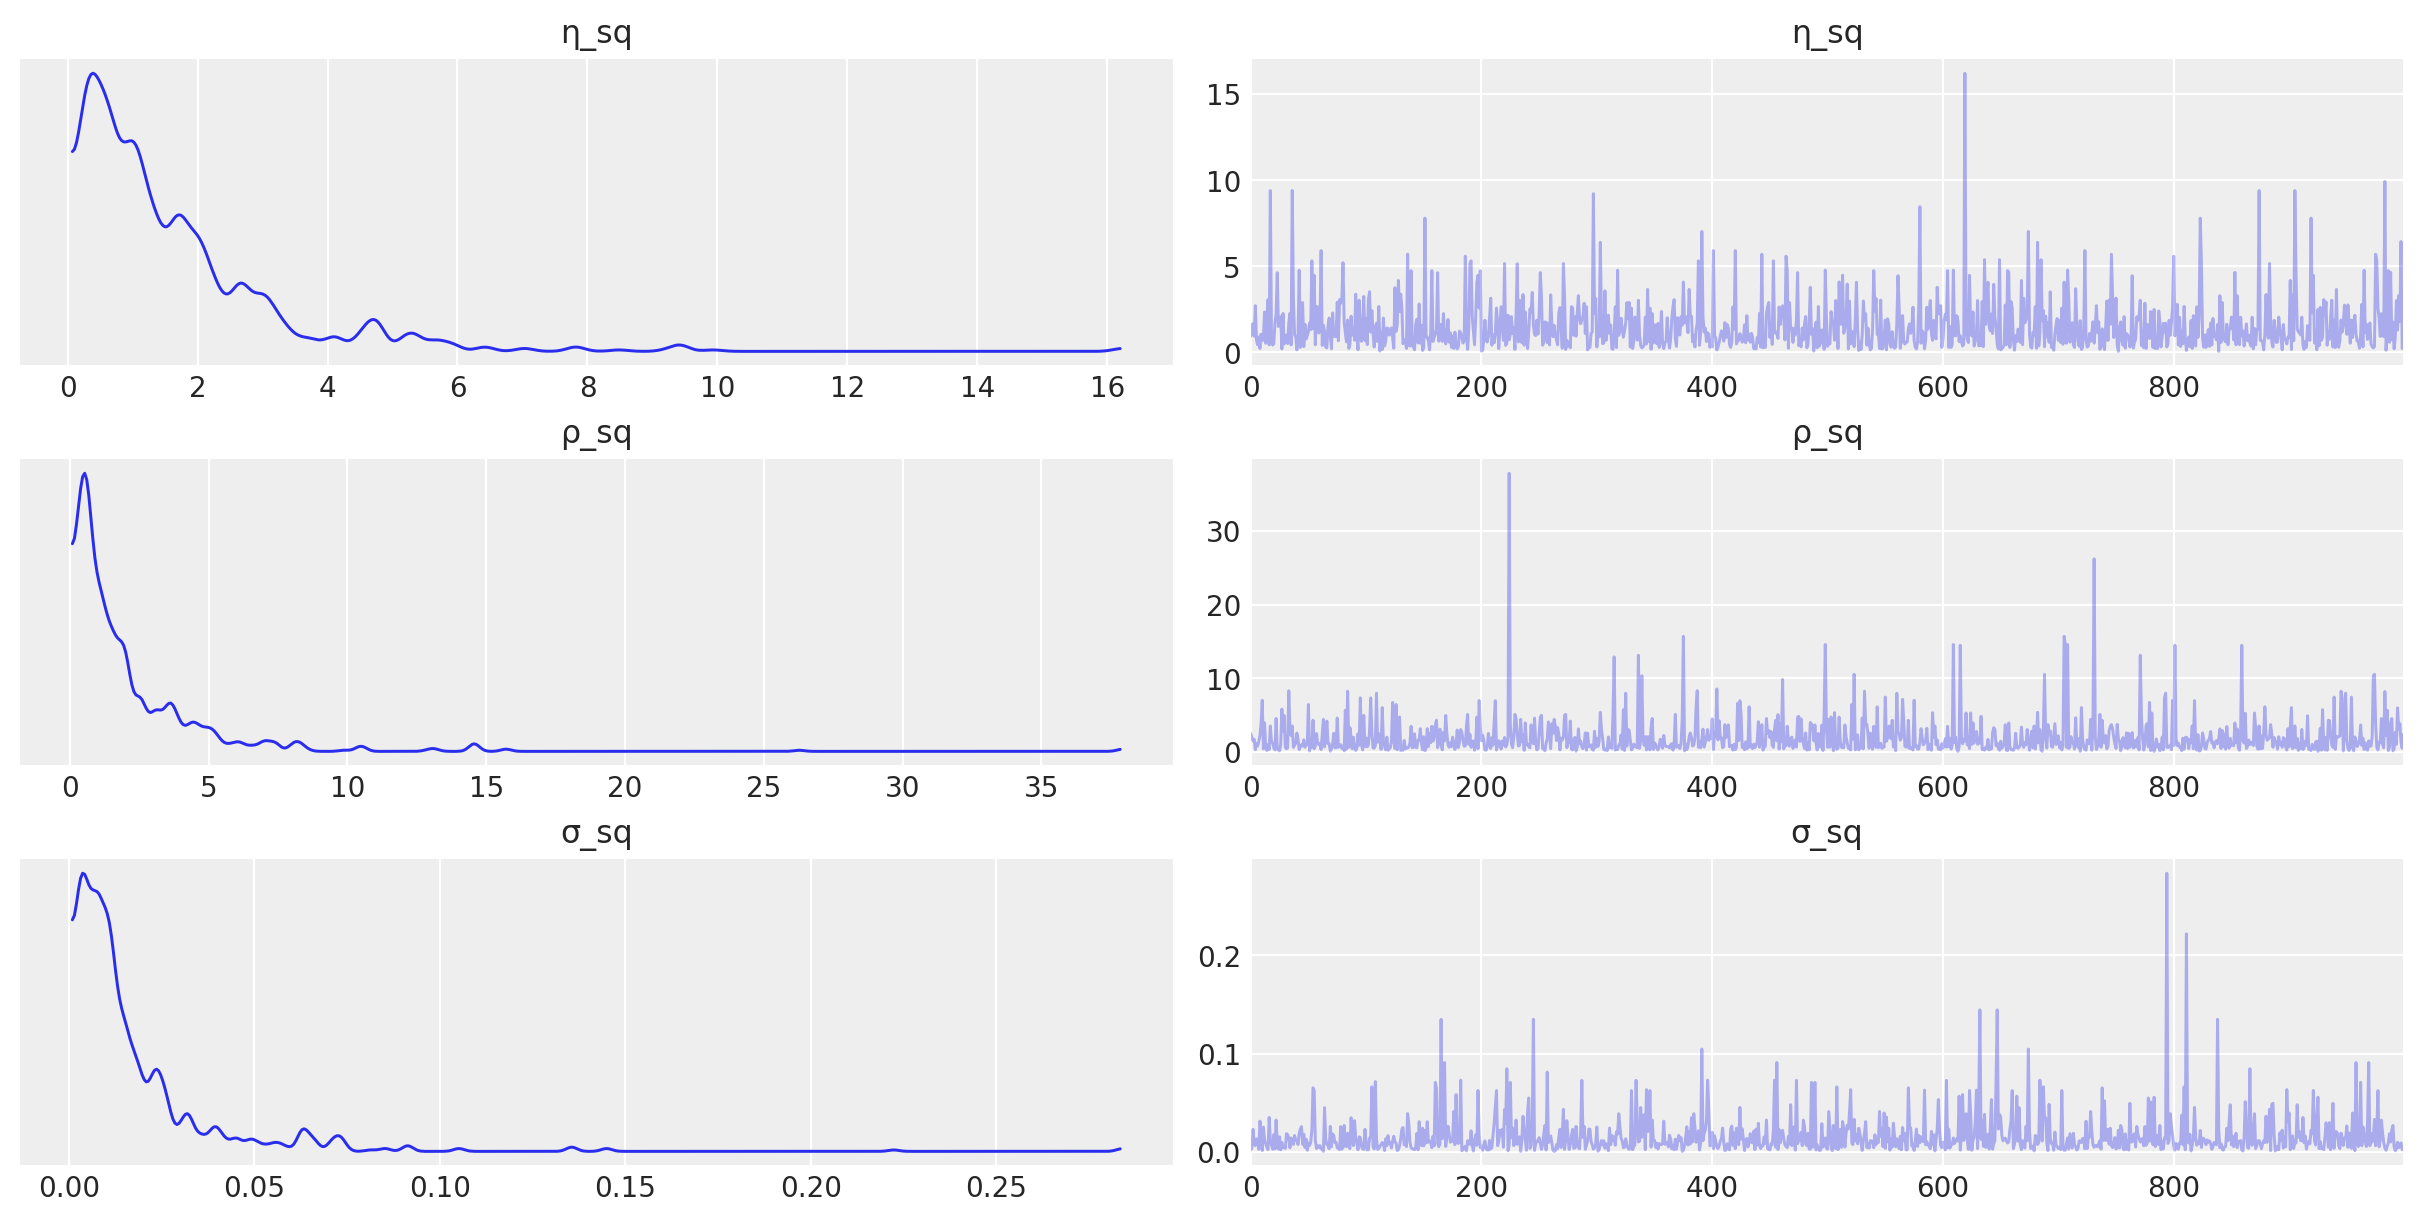

In [19]:
traceplot(gp_trace, var_names=["η_sq", "ρ_sq", "σ_sq"]);

In [20]:
y_pred = [
    np.random.multivariate_normal(m, S) for m, S in zip(gp_trace["μ_post"], gp_trace["Σ_post"])
]

(-100.0, 100.0)

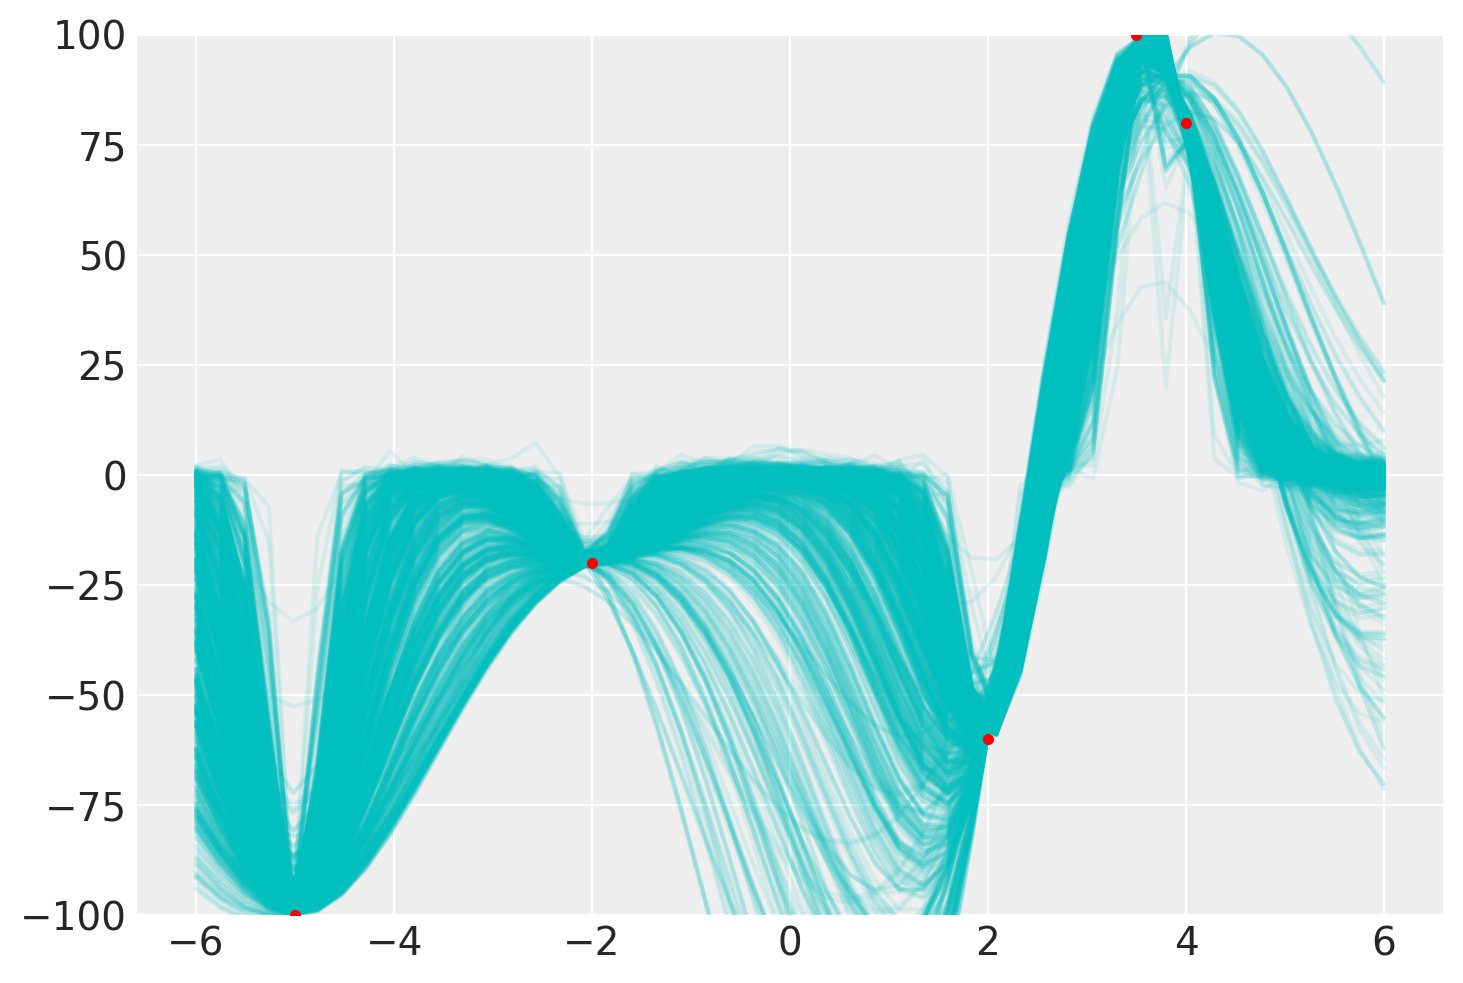

In [21]:
#η_sq = HalfCauchy("η_sq", 1)
#ρ_sq = HalfCauchy("ρ_sq", 1)
#σ_sq = HalfCauchy("σ_sq", 0.01)

for yp in y_pred:
    plt.plot(np.linspace(-6, 6), yp, "c-", alpha=0.1)
plt.plot(x, y, "r.")
plt.ylim(-100,100)

(-20.0, 20.0)

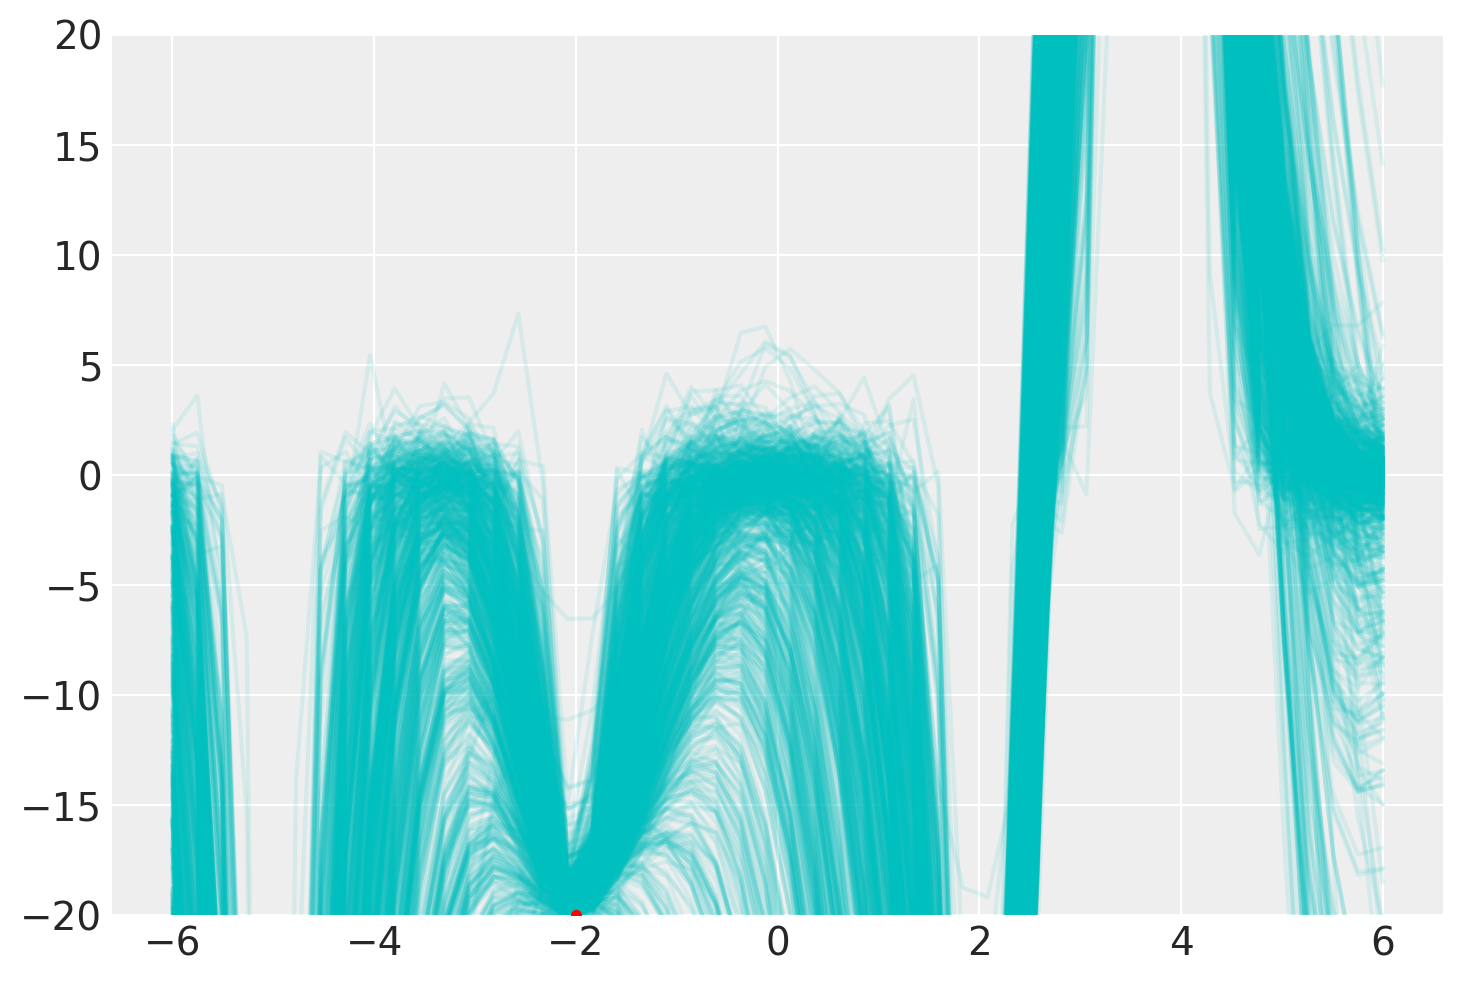

In [22]:
#η_sq = HalfCauchy("η_sq", 1)
#ρ_sq = HalfCauchy("ρ_sq", 1)
#σ_sq = HalfCauchy("σ_sq", 0.1)

for yp in y_pred:
    plt.plot(np.linspace(-6, 6), yp, "c-", alpha=0.1)
plt.plot(x, y, "r.")
plt.ylim(-20,20)

(-20.0, 20.0)

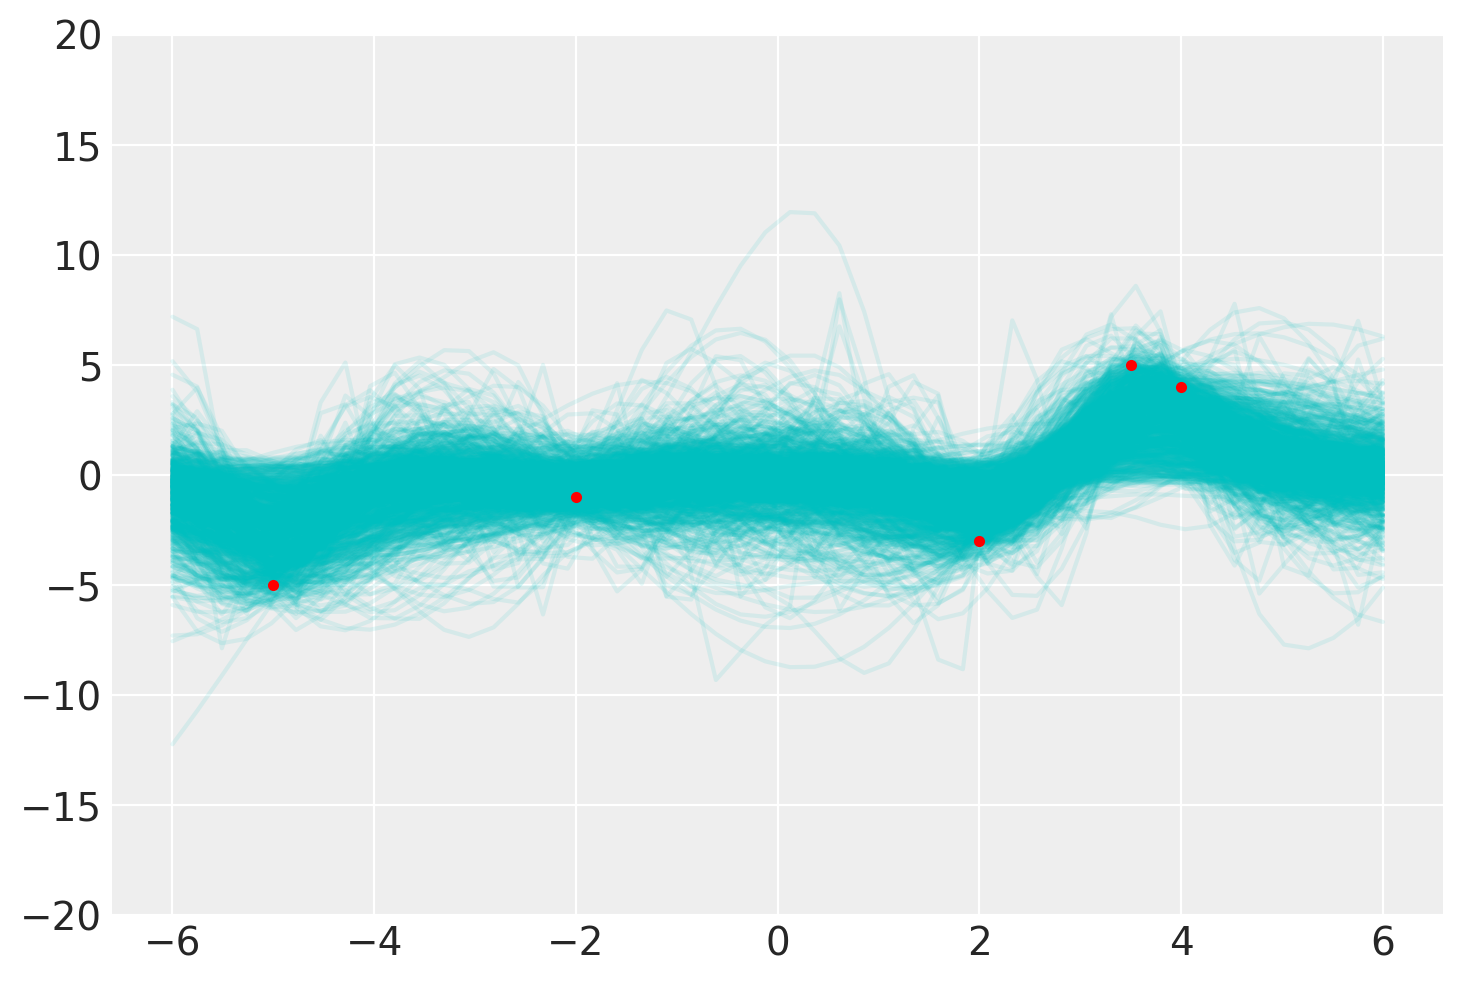

In [174]:
#η_sq = HalfCauchy("η_sq", 1)
#ρ_sq = HalfCauchy("ρ_sq", 1)
#σ_sq = HalfCauchy("σ_sq", 1)

for yp in y_pred:
    plt.plot(np.linspace(-6, 6), yp, "c-", alpha=0.1)
plt.plot(x, y, "r.")
plt.ylim(-20,20)

(-20.0, 20.0)

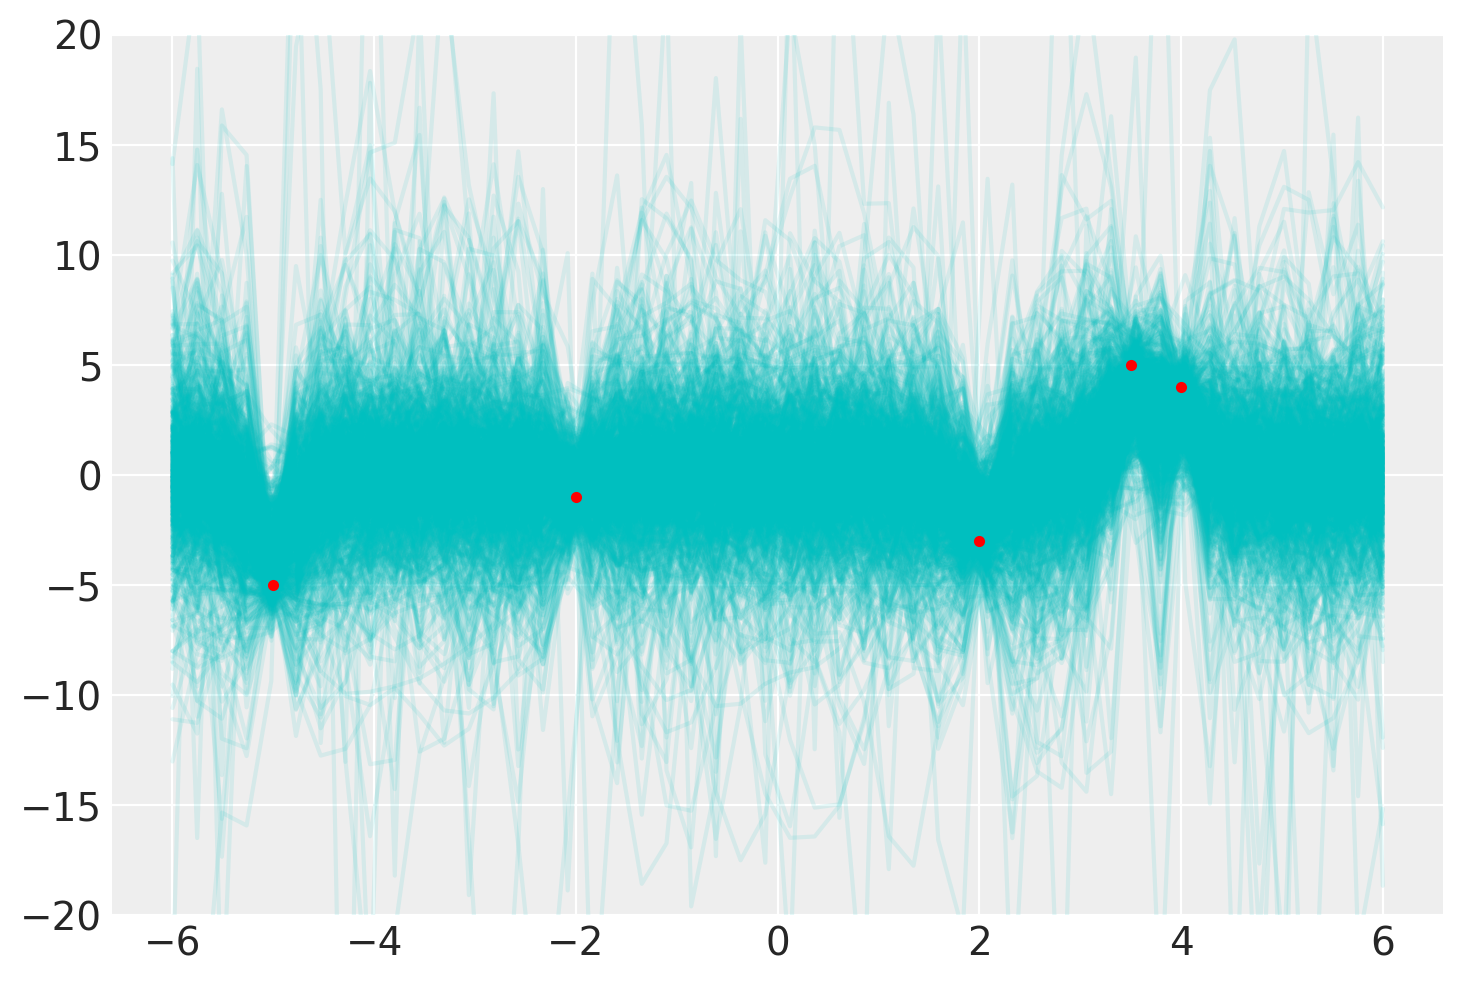

In [166]:
#η_sq = HalfCauchy("η_sq", 5)
#ρ_sq = HalfCauchy("ρ_sq", 10)

for yp in y_pred:
    plt.plot(np.linspace(-6, 6), yp, "c-", alpha=0.1)
plt.plot(x, y, "r.")
plt.ylim(-20,20)

(-20.0, 20.0)

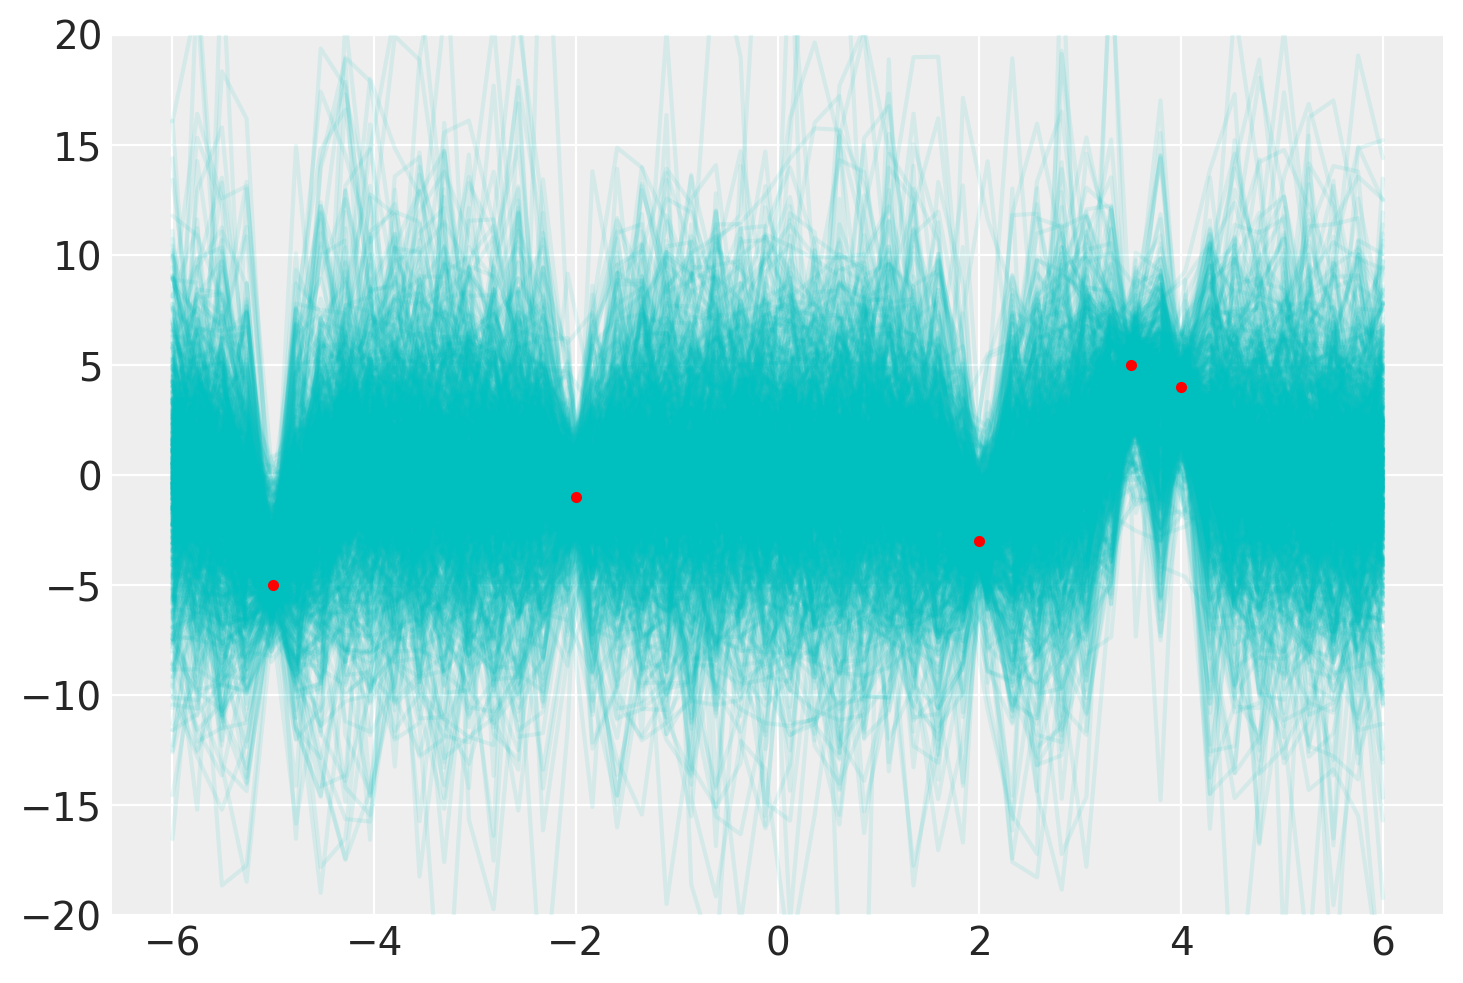

In [158]:
#η_sq = HalfCauchy("η_sq", 10)
#ρ_sq = HalfCauchy("ρ_sq", 10)

for yp in y_pred:
    plt.plot(np.linspace(-6, 6), yp, "c-", alpha=0.1)
plt.plot(x, y, "r.")
plt.ylim(-20,20)

(-20.0, 20.0)

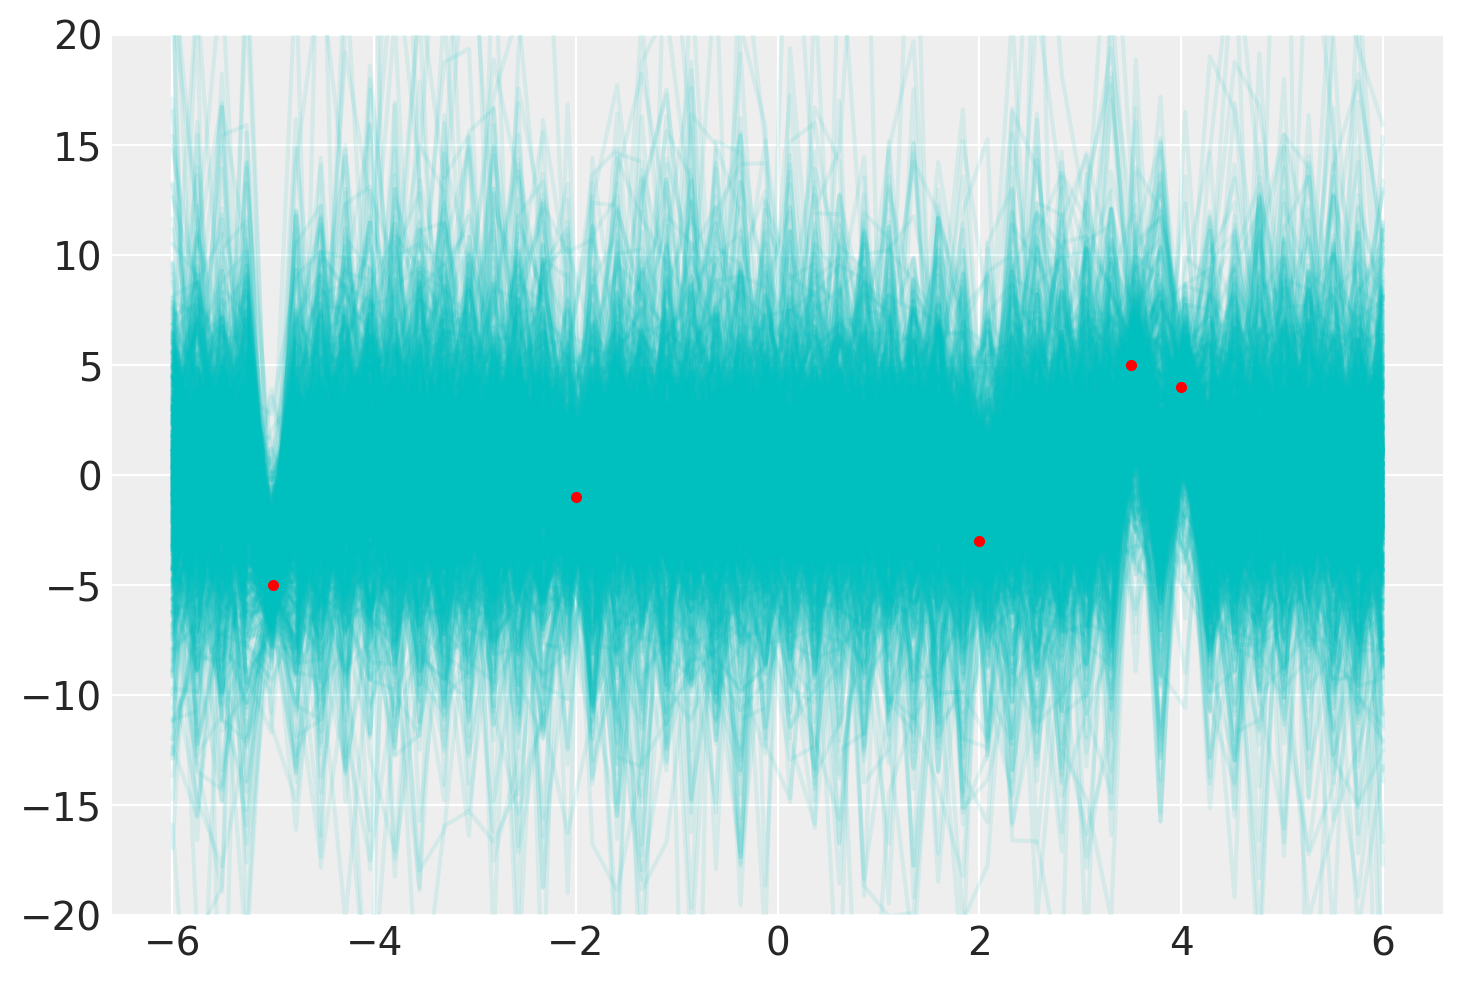

In [150]:
#η_sq = HalfCauchy("η_sq", 10)
#ρ_sq = HalfCauchy("ρ_sq", 50)

for yp in y_pred:
    plt.plot(np.linspace(-6, 6), yp, "c-", alpha=0.1)
plt.plot(x, y, "r.")
plt.ylim(-20,20)

(-20.0, 20.0)

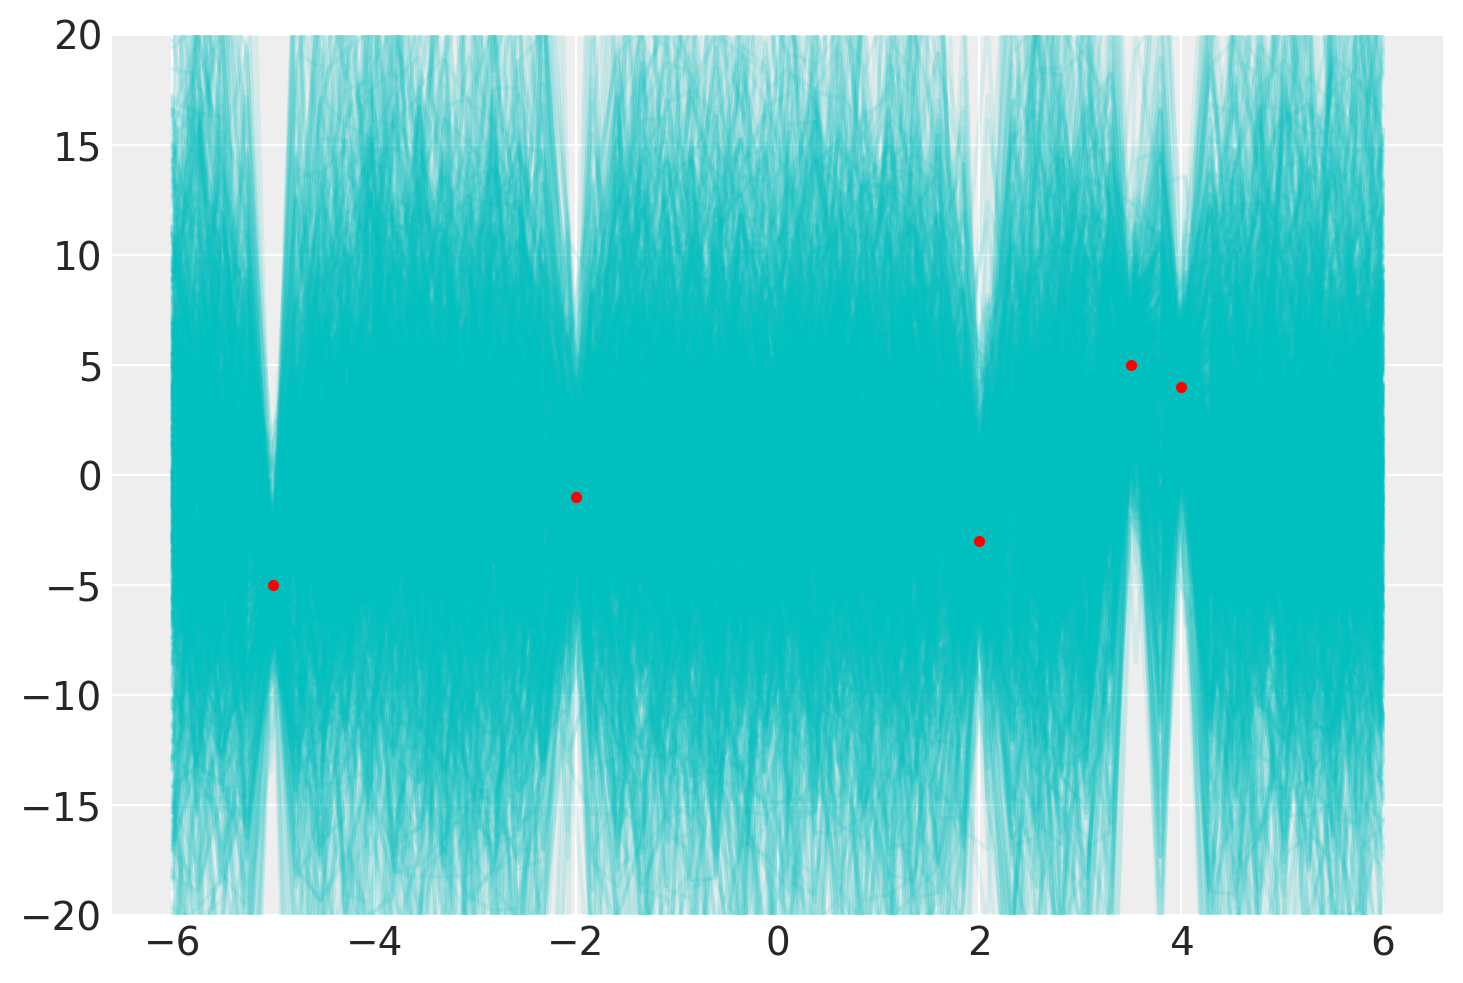

In [141]:
#η_sq = HalfCauchy("η_sq", 50)
#ρ_sq = HalfCauchy("ρ_sq", 10)

for yp in y_pred:
    plt.plot(np.linspace(-6, 6), yp, "c-", alpha=0.1)
plt.plot(x, y, "r.")
plt.ylim(-20,20)

# 3D GP

# 2d array

In [22]:
os.chdir('/app/data/')

import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [23]:
walker_data = pd.read_table('walker.txt', sep='\s+', index_col=0, skiprows=8, header=None, 
              names=['ID', 'Xloc', 'Yloc', 'V', 'U', 'T'])
walker_data.head()


Xloc  Yloc      V             U  T
ID                                    
1     11     8    0.0  1.000000e+31  2
2      8    30    0.0  1.000000e+31  2
3      9    48  224.4  1.000000e+31  2
4      8    69  434.4  1.000000e+31  2
5      9    90  412.1  1.000000e+31  2

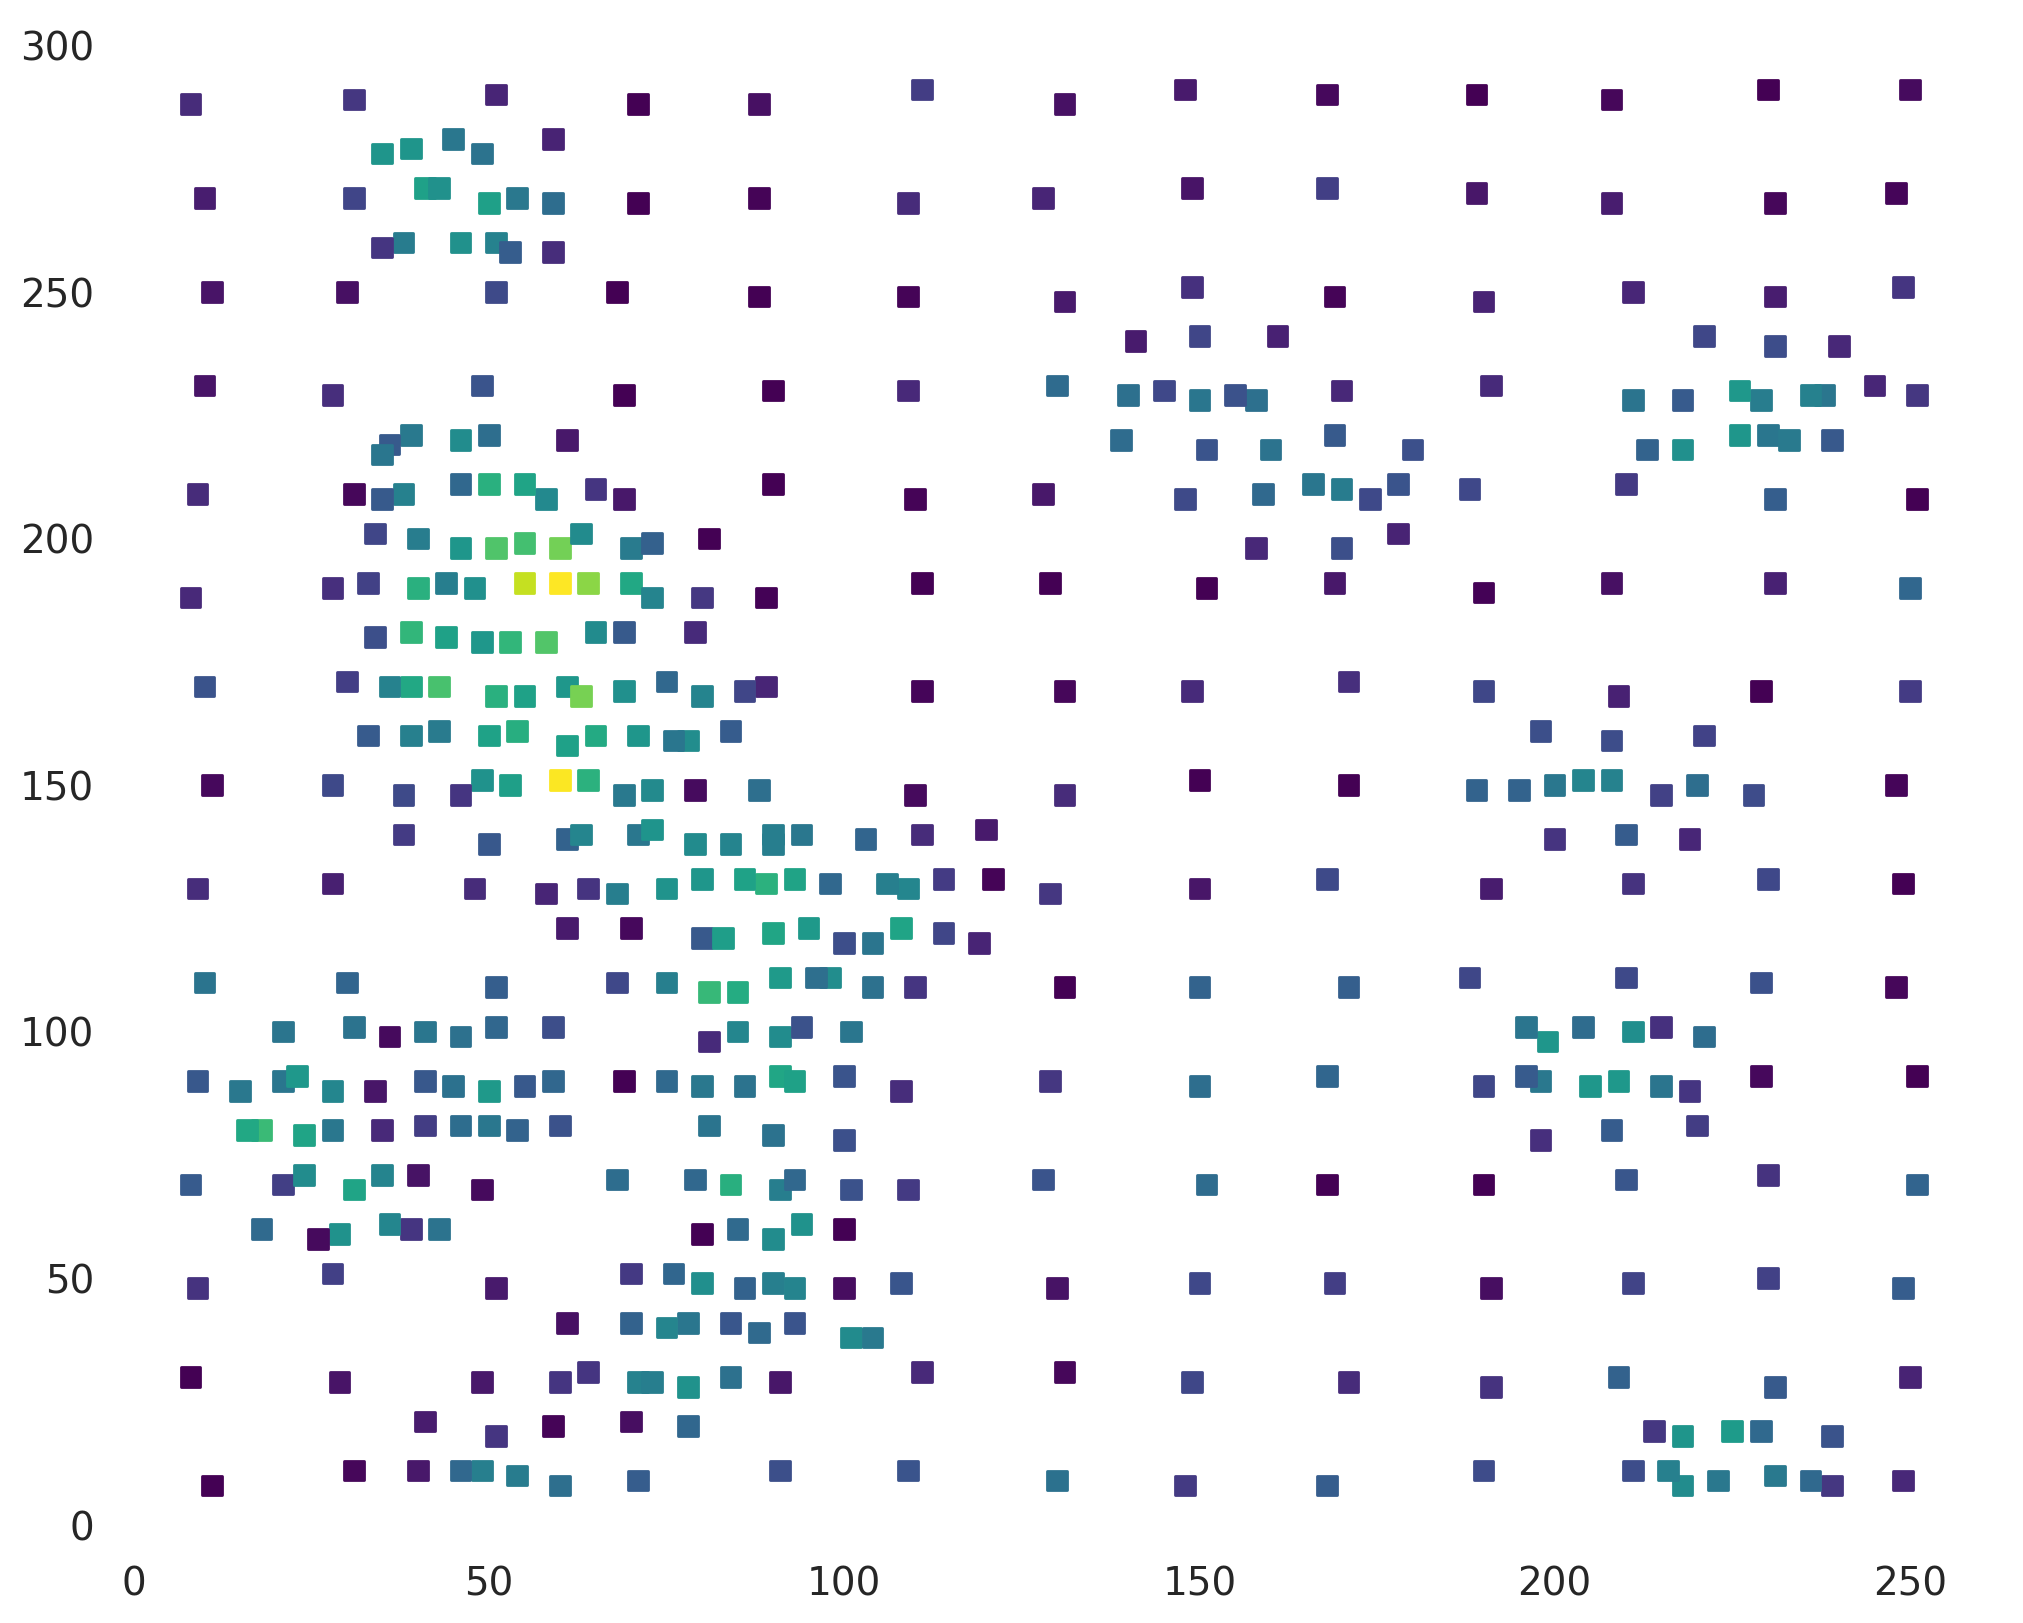

In [24]:
nx = 40
x1, x2 = np.meshgrid(np.linspace(0,300,nx), np.linspace(0,300,nx))
X = np.concatenate([x1.reshape(nx*nx, 1), x2.reshape(nx*nx, 1)], 1)

X_obs = walker_data[['Xloc', 'Yloc']].values
y_obs = walker_data.V.values

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(X_obs[:,0], X_obs[:,1], s=50, c=y_obs, marker='s', cmap=plt.cm.viridis);

In [25]:
nd = 15
xu1, xu2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1)

In [26]:

with pm.Model() as spatial_model:
    
    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)
    sn2 = pm.HalfCauchy("sn2", beta=3)

    K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    
    #
    gp_spatial = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    
    # observations
    obs = gp_spatial.marginal_likelihood("obs", X=X_obs, Xu=Xu, y=y_obs, noise=sn2)

    mp = pm.find_MAP()

In [27]:
Σ = T.fill_diagonal(l * T.exp(-sf2 * K), l + sn2)

TypeError: Unsupported dtype for TensorType: object

In [ ]:
mp

In [ ]:
nd = 30
z1, z2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Z = np.concatenate([z1.reshape(nd*nd, 1), z2.reshape(nd*nd, 1)], 1)
print(Z)

In [ ]:
with spatial_model:

    f_pred = gp_spatial.conditional('f_pred', Z)

In [ ]:
print(f_pred)

In [ ]:
with spatial_model:
     samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'], samples=1000)

In [ ]:
with sns.axes_style("white"):

    plt.figure(figsize=(10,8))
    ax = sns.heatmap(samples['f_pred'].mean(0).reshape(nd, nd), cmap='viridis')
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.set_xticklabels([])